# Pandemic Journaling Project
## Thomas Rosenthal
### Assignment 3: INF2199

**Prereqs**

*You need wordcloud for this notebook*

In [1]:
#pip install wordcloud
pass

*You need langdetect for this notebook*

In [2]:
#pip install langdetect
pass

*You need plotly.express for this notebook*

In [3]:
#pip install plotly.express
pass

_You need textblob for this notebook_

In [4]:
#pip install textblob
pass

_You **MUST DOWNLOAD** nltk's resources and place the folder "nltk_data" within your wd (or root or Conda root)_

In [5]:
#nltk.download()
#nltk.download('wordnet')
pass

## Introduction

> _Remember how you felt the first lockdown? How about the second lockdown? How about the, wait, how many lockdowns are we up to now?_

The pandemic has dragged on far longer than any of us likely imagined. Many of us have been living a "new normal" for more than a year now. In that time, the world has changed dramatically; our lives seemingly exist within a history being written while we log in to Zoom for another meeting. As the days have turned to months, it has become harder and harder to remember both our personal histories and the events that have transpired.

The Pandemic Journaling Project has aimed to capture our thoughts, feelings, and sentiments by establishing an anthropological database of several thousand anonymous weekly journal entries. These "digital diaries...may be the most complete record of our shifting moods in this isolating year" (Carey, 2021). 

Through a combination of R-based webscraping, python-based Natural Language Processing (NLP), and visualizations, I have collected and analysed 1,000 of these entries to examine our collective thoughts. I was particularly interested in this dataset because it will eventually be made public to researchers. Initial results from the researchers at the University of Connecticut and Brown University reveal much of what we would expect. Themes emerge: political protests and insurrection, cataclysmic fires raging in the Western US, and [Existential Dread](https://i.imgur.com/d9KdAvH.jpeg). 

This notebook explores word usage, sentiments, and begins to scratch the surface of the many human interest stories that will certainly arise from the Pandemic Journaling Project.

**Audience**

I thought a lot about my mom while working with this dataset. She's the type of person who would contribute to the Pandemic Journaling Project. She's intelligent, but also compassionate, and truly a lifelong learner. She's also from the US, and this project is almost entirely through a US lens (it does aim to be a North American lens, with some Spanish entries and a few referencing Canada as well). There are many similar people to my mother&mdash;they are the type of people who can be enticed by an interesting data visualization, but it will never be their primary interest in a news story. Rather, they expect data/visualizations to connect back to the people they are representing. Because the Pandemic Journaling Project is aiming to be an anthropological artifact, data analytics are only possible after its primary _human_ function has been met (a place for us to collectively record our thoughts, an account of what happened). Trying to capture this through data science is challenging. 

Additionally, I'd like this work to be interesting to the researchers and creators of the Pandemic Journaling Project at UConn and Brown. 

**Biases**

Without full access to the Pandemic Journaling Project dataset, it is difficult to explore the full depths of the project. The New York Times reported that there were approximately 7,000 journal entries by March 2021. This analysis focuses on the "Featured" 1,000. It is unknown what qualifiers are attached to a _featured_ story. 

The website states: 

>"Each week, we post a few journal entries that participants have given us permission to share anonymously."

This is a very broad filter. This notebook doesn't make any substantive claims, as this filter might seriously affect the types of entries we find within the dataset. The filtering is a _human_ process. As such, it has inherited the biases of its _human_ curators. At this stage, we cannot know what this entails.

Additionally, I myself am interested in telling a very specific type of pandemic story. A year into the pandemic, I'm tired. I'm bored of hearing about it. I'm bothered by the obvious pointlessness of our lives. I'm frustrated with the incompetency of our elected officials. But above all else, I'm an immensely privileged person. I know none of the real hardships people have faced. The pandemic is a nuisance, rather than a life-changing experience. As such, my analysis portrays these biases. I'm interested in pointing to emotions I am also experiencing. In my final graphics, I select words (out of the many) that I personally found interesting. I welcome further analysis and design that would allow another (python-based) user to explore their own interests.

From a technical standpoint, my scraping was limited to text-only entries (there are also audio and photo entries). This filtered out roughly 250 entries. Additionally, 116 Spanish entries were filtered out. This is my first real NLP analysis done in python. I've worked hard to write good code, but effort does not replace experience.

### Data Preparation

In [6]:
#import functional libraries
import os
import numpy as np
import pandas as pd
import numpy as np
import decimal as dc
import random

#import NLP libraries
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from langdetect import detect 

#impoort graphical libraries
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px

%matplotlib inline

**Scraped Data**

The Pandemic Journaling Project has not yet made its data available. Using R, I scraped the "[Featured](https://www.pandemicjournalingproject.org/en/archive/featured?search=&entry_type=text_only&commit=Search)" stories (see §Appendix) in order to create the raw dataset. As of April 2, 2021 there were 1,116 journal entries available for scraping. Because the pandemic is ongoing, the dataset can be recreated, and this analysis can be updated.

The scraping was straightforward. HTML divider tags were consistent so it was possible to pull out story content without the journaling prompt. Journal IDs were stored in a parent divider, allowing the entries to be joined with it. Using `rvest` and a for loop for each page (pages are 25 entries in length) of the Pandemic Journaling Project, I put these into a very simple dataframe. Stories are stored as "entries".

In [7]:
raw = pd.read_csv('data/PandemicJournalingProject_20210402.csv')

In [8]:
raw.head()

rowname                  ids  \
0        1  journal-entry-12333   
1        2  journal-entry-12329   
2        3   journal-entry-1909   
3        4   journal-entry-1628   
4        5  journal-entry-12110   

                                             entries  
0   It's still the pandemic, although the Chauvin...  
1   I found out I was pregnant ( a surprise) in J...  
2  Bueno, me he dado cuenta que  me he vuelto un ...  
3   Antes de la pandemia, eramos otras personas.\...  
4  Only twice in the past year has any stranger a...

**Data Preparation**

Several visualizations were considered:

1. a simple word cloud to think about the data

2. sentiment scores (either in aggregate or over time)

3. ngram usage similar to [Google's NGram Viewer](https://books.google.com/ngrams/graph?content=pandemic&year_start=1800&year_end=2019&corpus=26&smoothing=3&direct_url=t1%3B%2Cpandemic%3B%2Cc0)

The latter two required basic NLP manipulation (see §Tokenization for Basic NLP). Because the dataframe did not include any indication as to _when_ journal entries were created, entries were grouped to their nearest Saturday, using George Floyd's murder as an anchor (several early entries referred explicitly to this event) and proceeding forward until Saturday, April 3, 2021. The grouping mechanism assumed the same number of entries were featured each week. Additional events were manually checked for accuracy (such as Christmas and the Capitol Riots). The grouping was generally close, but actual dates would be highly beneficial. 

Two sentiment analysis libraries were used: `NLTK` and `textblob`. Ultimately I was very unsatisfied with sentiment analysis because most pandemic-related words were "neutral" to these libraries' dictionaries. These analyses would not be included in a narrative version of this work.  

### Wrangling

In [9]:
#remove spanish entries
raw['lang'] = raw['entries'].apply(lambda x: detect(x) == 'en')
eng = raw.loc[raw.lang, :]

In [10]:
#turn ids like "journal-entry-12333" into an id field (12333) to sort on
eng[['del','del1', 'id']] =eng['ids'].str.split('-', expand = True)
del eng['del']
del eng['del1']
eng["id"] = eng["id"].astype(str).astype(int)
#move to front of dataframe
col = eng.pop("id")
eng.insert(0, col.name, col)

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3062: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
#remove unnecessary columns
del eng['rowname']
del eng['lang']

In [12]:
eng.head()

id                  ids  \
0  12333  journal-entry-12333   
1  12329  journal-entry-12329   
4  12110  journal-entry-12110   
5  12147  journal-entry-12147   
6  12093  journal-entry-12093   

                                             entries  
0   It's still the pandemic, although the Chauvin...  
1   I found out I was pregnant ( a surprise) in J...  
4  Only twice in the past year has any stranger a...  
5  Sitting on quite a lot of anger and something ...  
6   The pandemic doesn't feel real anymore. That ...

### Word Cloud

A typical start for any NLP is to build a word cloud. It gives a high-level sense of word frequency. Word clouds are not hugely useful; they don't show any relationships between words and are the most susceptible to common words that aren't included in a stop list. To make this analysis more interesting, I've used one of the largest stop lists I could find (_see this [discussion](https://gist.github.com/sebleier/554280)_). I've chosen to leave pandemic-related words within the word cloud&mdash;they are, after all, the context in which the Pandemic Journaling Project exists. 

In [13]:
text = " ".join(i for i in eng.entries)

In [14]:
#https://github.com/stopwords-iso/stopwords-en/blob/master/stopwords-en.txt
words = []
for word in open('data/stopwords.txt'):
    words.append(word.rstrip('\n'))

In [15]:
stopwords = set(words)

In [16]:
wordcloud = WordCloud(stopwords=stopwords, random_state=3,background_color="black").generate(text)

In [17]:
#generate a grey word with any lum between 80 and 100 
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(80, 100)

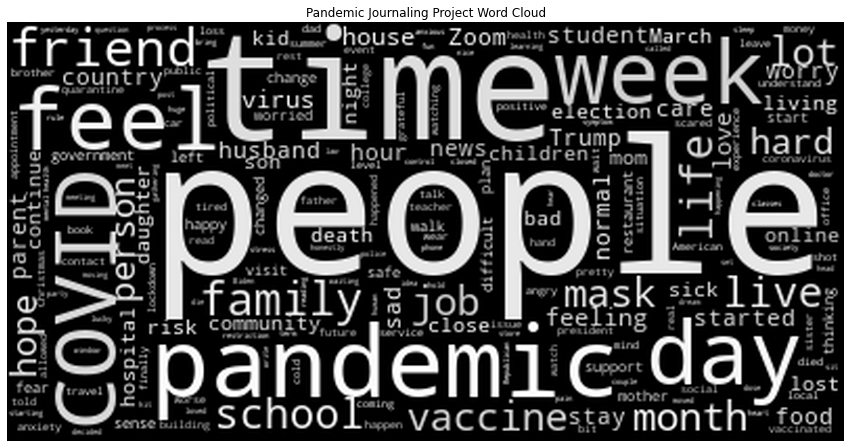

In [18]:
plt.figure(figsize=[15,15])

plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3)
           #interpolation selection was based on resolution for this figsize, this is the BEST resolution, sorry      
           ,interpolation='spline36') 
plt.axis("off")
plt.title("Pandemic Journaling Project Word Cloud")
#plt.savefig('word_cloud.png')
plt.show()

<sup> **Figure 1:** Word Cloud of all Entries </sup>

The word cloud suggests two interesting trends: journals are often about _other_ people. Entries talk about friends, family, children, politicians, and everyone else. Are people wearing their masks? What's happening with the election? How will students succeed in online environments? The journals are also reflections of self&mash;speaking to our collective emotional and mental health. Things are hard, lives have changed, and time continues to pass. Single keywords are evocative: "Zoom" (top middle), "hope" (bottom left), "time" (top), "worry" (top right), "vaccine" (bottom middle), "death" (center).

If nothing else, the word cloud captures the relentlessness of the pandemic. No one wants to journal the same thing over and over again, but the pandemic continues nefariously despite other world-changing events. Later word frequency (`NLTK FreqDist`) tabulates the exact frequencies and distributions of these words over time.

### Tokenization for Basic NLP

In order to perform any NLP, the entries must be tokenized. Using the `NLTK` package, entries were parsed and stop words were removed. Lemmatization was explored first as an alternative to stemming. I hoped lemmatized text would simplify some context and reduce the overall variety of words, but the outcomes were less interesting.

The following compares lemmatized text and its original:

> I found out I wa pregnant ( a surprise) in July. The appointment were different being fully masked and my husband wasn't allowed to come along. When in September we realized this pregnancy wa difficult and would be filled with specialists, that proved even more difficult by having to go it alone. My husband joined me on most appointment by speaker phone or FaceTime, but a we all know from pandemic times- it's not the same.

> I found out I was pregnant ( a surprise) in July. The appointments were different being fully masked and my husband wasn't allowed to come along. When in September we realized this pregnancy was difficult and would be filled with specialists, that proved even more difficult by having to go it alone. My husband joined me on most appointments by speaker phone or FaceTime, but as we all know from pandemic times- it's not the same. 

The difference tended to be minor, so the Lemmatizer was not used.

Further analysis with stemming was interesting, but proved hard to "reverse". It seemed difficult to balance presenting unstemmed words (e.g. "worr" for worry, worrying, worries, worried) and the slightly better analysis stemming produced. Some stop words still appeared, even after the stop list was stemmed (or lemmatized).

In [19]:
#tokenize the words as column
eng['tokenized'] = eng['entries'].apply(word_tokenize)
#tokenize the words
text = eng['entries'].apply(word_tokenize)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
#if you're thinking about stemming/lemmatizing
#this code works, but I saw too many stop words even after lemmatizing the stoplist, so went without


# lemmatizer = nltk.stem.WordNetLemmatizer()
# w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# def lemmatize_text(entries):
#     return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(entries)]
# eng['text_lemmatized'] = eng.entries.apply(lemmatize_text)
# text = eng['text_lemmatized']
# stop_words = [[lemmatizer.lemmatize(word) for word in word_tokenize(s)]
#               for s in stopwords]


In [21]:
#if you're thinking about stemming/lemmatizing
#this code works, but I saw too many stop words even after stemming the stoplist, so went without

# sno = nltk.stem.SnowballStemmer('english')
# eng['text_stemmed'] = eng['tokenized'].apply(lambda x: [sno.stem(y) for y in x])

# text = eng['text_stemmed']
# stop_words = [[sno.stem(word) for word in word_tokenize(s)]
#                for s in stopwords]

In [22]:
#remove non-alpha characters, stop words, set up for FreqDist
words = sum(text, [])
words = [w for w in words if w.isalpha()]
words = [w for w in words if w.lower() not in stopwords]

#run with this line if you use the lemmatizer/stemming
# words = [w for w in words if w.lower() not in stop_words]

In [23]:
#run nltk Freq dist, make it a dataframe
fd = nltk.FreqDist(words)
frequency = pd.DataFrame(list(fd.items()), columns = ["word","frequency"]) 
frequency.sort_values(by=['frequency'], ascending=False).head(10)

word  frequency
107    people        886
0    pandemic        646
174      time        534
115      feel        414
249      week        396
662       day        328
9     friends        321
10     family        320
756     COVID        261
228      life        261

**Bigrams/Triagrams**

In [24]:
#was just curious what bigrams were there
finder = nltk.collocations.BigramCollocationFinder.from_words(words)
bigram = pd.DataFrame(list(finder.ngram_fd.most_common()), columns = ["bigram","frequency"]) 
bigram.sort_values(by=['frequency'], ascending=False).head(8)

bigram  frequency
0      (mental, health)         41
2        (health, care)         34
1     (friends, family)         34
3  (social, distancing)         32
4         (wear, masks)         30
5          (wear, mask)         28
6     (family, friends)         28
7       (social, media)         28

In [25]:
#likewise trigrams
finder = nltk.collocations.TrigramCollocationFinder.from_words(words)
trigram = pd.DataFrame(list(finder.ngram_fd.most_common()), columns = ["trigram","frequency"]) 
trigram.sort_values(by=['frequency'], ascending=False).head(8)

trigram  frequency
0      (health, care, workers)          7
1       (Black, Lives, Matter)          7
2    (universal, health, care)          6
3   (Fluttering, cold, breeze)          5
4       (cold, breeze, dances)          5
5       (breeze, dances, skin)          5
9   (post, infection, fatigue)          4
12           (skin, pull, bow)          4

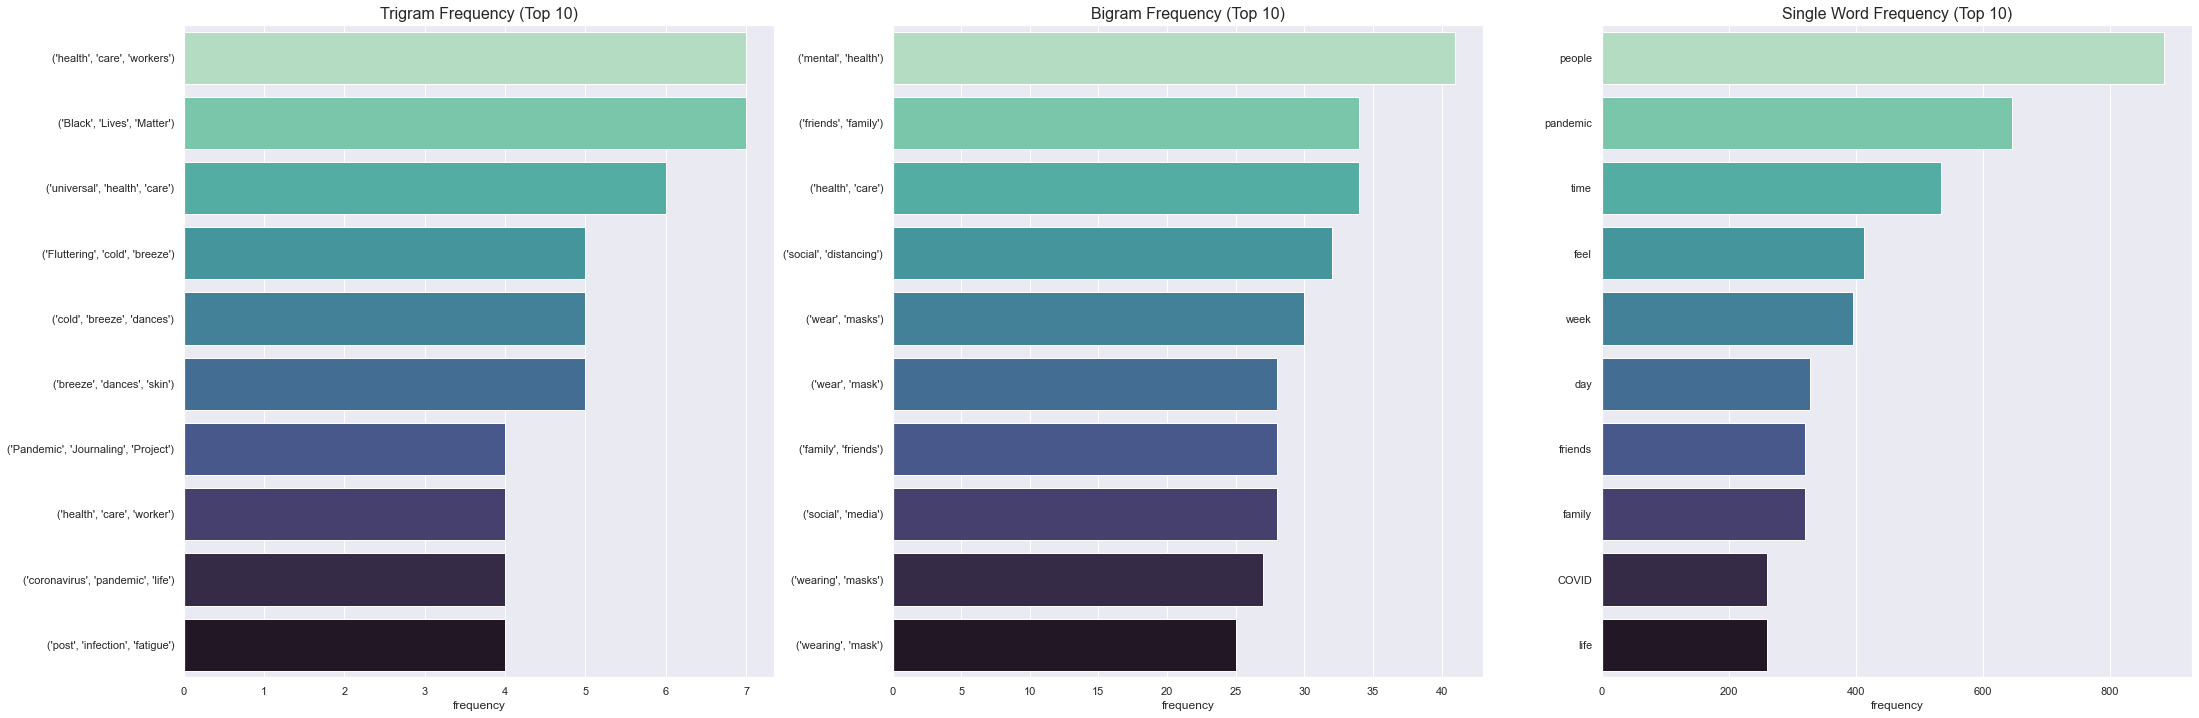

In [26]:
#set gridspec
gs = gridspec.GridSpec(1, 3, wspace=0.2, hspace=0.5) 

#set fig parameters
sns.set(style="darkgrid", color_codes=True)
pal = sns.color_palette("mako", 10)
f = plt.figure(figsize=(36,12))

#Left Plot
ax = plt.subplot(gs[0,0])
ax = sns.barplot(y="trigram", x="frequency", data=trigram.head(10), palette=np.array(pal[::-1]))
ax.set_ylabel('')    

#Middle Plot
ax1 = plt.subplot(gs[0,1])
ax1 = sns.barplot(y="bigram", x="frequency", data=bigram.head(10), palette=np.array(pal[::-1]))
ax1.set_ylabel('')    

#Right Plot
ax2 = plt.subplot(gs[0,2])
ax2 = sns.barplot(y="word", x="frequency", 
            data=frequency.sort_values(by=['frequency'], ascending=False).head(10), palette=np.array(pal[::-1]))
ax2.set_ylabel('')    

ax.set_title('Trigram Frequency (Top 10)', fontdict = {'fontsize' : 16})
ax1.set_title('Bigram Frequency (Top 10)', fontdict = {'fontsize' : 16})
ax2.set_title('Single Word Frequency (Top 10)', fontdict = {'fontsize' : 16})
#plt.savefig('tri_bigrams.png')
plt.show()

<sup> **Figure 2:** Trigram, Bigram, and Word Frequencies </sup>

Bigrams and trigrams are quite interesting. "Wear a mask" and its variants appear frequently in bigrams. Both bigrams and trigrams show healthcare themes: "health care", "health care workers", and the need for "universal health care". Single word frequencies are presented to show how highly frequent terms like "friends" and "family" appear together in the bigrams (as both "friends and family" and "family and friends").

More work to analyze single word frequency follows.

### Sentiment Analysis

Following basic NLP, it seemed natural to perform some simple sentiment analysis. Conceptually, we imagine that sentiment analysis will highlight the difficulties of life during the pandemic. In reality, the results were [disappointing](https://i.imgur.com/3YrKJGp.jpg). Entries expressed worry or longing for friends and family; sentiment analysis would classify these as **positive** entries because of the high frequency for positive terms ("friends" and "family"), relative to the low frequency for negative terms ("worry" or "longing") which were used as context but sparingly. 

**The following example demonstrates this problem:**

> "It's still the pandemic, although the Chauvin trial is a close second. The pandemic surge is happening, AGAIN. I despair for America and the rest of the world. I have friends and family in Europe, where they are again in lockdown. I hear news reports of vaccine refusers (even health care workers) in Africa. Vaccine supply is spotty at best in the rest of the world, and those in rural, underdeveloped countries are at the mercy of their governments. This is a virus that keeps mutating. I suspect it will be the main news story for years." 

Sentiment Analysis Score (`NLTK VADER`): 'Negative': 0.044, 'Neutral': 0.829, 'Positive': 0.127
- Positive: ['friends', 'care', 'best', 'mercy']
- Negative: ['despair', 'suspect']

Sentiment Polarity Score (`textblob`): 0.29167

There's little argument that this entry is not positive. It's worried, it's anxious, it's exhausted. But sentiment analysis classifies this as _slightly positive_  (`textblob` polarity scores range from -1 to 1, where 1 is positive; `NLTK` ratios show that positive and negative words are occurring in proportion to the text that falls into those categories).

A more experienced NLP approach might be able to find greater sentiment value within the entries. 

In [27]:
#SentimentIntensityAnalyzer alongside polarity_scores from NLTK (entire dataset)
#results show nearly entirely neutral
text = " ".join(i for i in eng.entries)
sia = SentimentIntensityAnalyzer()
score = sia.polarity_scores(text)
print('\nScores (Entire Dataset):', score)


Scores (Entire Dataset): {'neg': 0.088, 'neu': 0.819, 'pos': 0.093, 'compound': 1.0}


In [28]:
#this shows a concept where you can see what words SIA placed in pos, neutral, and negative
#run on the same entry as the introduction 

tokenized_sentence = eng.tokenized[0]

sia = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for word in tokenized_sentence:
    if (sia.polarity_scores(word)['compound']) >= 0.1:
        pos_word_list.append(word)
    elif (sia.polarity_scores(word)['compound']) <= -0.1:
        neg_word_list.append(word)
    else:
        neu_word_list.append(word)

score = sia.polarity_scores(eng.entries[0])

print('Positive:',pos_word_list)        
print('Neutral:',neu_word_list)    
print('Negative:',neg_word_list) 
print('\nScores:', score)

Positive: ['friends', 'care', 'best', 'mercy']
Neutral: ['It', "'s", 'still', 'the', 'pandemic', ',', 'although', 'the', 'Chauvin', 'trial', 'is', 'a', 'close', 'second', '.', 'The', 'pandemic', 'surge', 'is', 'happening', ',', 'AGAIN', '.', 'I', 'for', 'America', 'and', 'the', 'rest', 'of', 'the', 'world', '.', 'I', 'have', 'and', 'family', 'in', 'Europe', ',', 'where', 'they', 'are', 'again', 'in', 'lockdown', '.', 'I', 'hear', 'news', 'reports', 'of', 'vaccine', 'refusers', '(', 'even', 'health', 'workers', ')', 'in', 'Africa', '.', 'Vaccine', 'supply', 'is', 'spotty', 'at', 'in', 'the', 'rest', 'of', 'the', 'world', ',', 'and', 'those', 'in', 'rural', ',', 'underdeveloped', 'countries', 'are', 'at', 'the', 'of', 'their', 'governments', '.', 'This', 'is', 'a', 'virus', 'that', 'keeps', 'mutating', '.', 'I', 'it', 'will', 'be', 'the', 'main', 'news', 'story', 'for', 'years', '.']
Negative: ['despair', 'suspect']

Scores: {'neg': 0.044, 'neu': 0.829, 'pos': 0.127, 'compound': 0.8591}


In [29]:
#same entry but with textblob
analysis = TextBlob(eng.entries[0])
print(analysis.sentiment)  

Sentiment(polarity=0.2916666666666667, subjectivity=0.15833333333333333)


In [30]:
ind_eng = eng.reset_index(drop=True)

In [31]:
#add polarity to dataframe as a column 
polarity = 0
pol = []
for i in ind_eng.index:
    analysis = TextBlob(ind_eng.entries[i])
    
    polarity = analysis.sentiment.polarity
    pol.append(polarity)
    
se = pd.Series(pol)
ind_eng['polarity'] = se.values

In [32]:
ind_eng.head()

id                  ids  \
0  12333  journal-entry-12333   
1  12329  journal-entry-12329   
2  12110  journal-entry-12110   
3  12147  journal-entry-12147   
4  12093  journal-entry-12093   

                                             entries  \
0   It's still the pandemic, although the Chauvin...   
1   I found out I was pregnant ( a surprise) in J...   
2  Only twice in the past year has any stranger a...   
3  Sitting on quite a lot of anger and something ...   
4   The pandemic doesn't feel real anymore. That ...   

                                           tokenized  polarity  
0  [It, 's, still, the, pandemic, ,, although, th...  0.291667  
1  [I, found, out, I, was, pregnant, (, a, surpri...  0.023316  
2  [Only, twice, in, the, past, year, has, any, s... -0.180000  
3  [Sitting, on, quite, a, lot, of, anger, and, s... -0.034802  
4  [The, pandemic, does, n't, feel, real, anymore... -0.018750

In [33]:
polarity = 0
spositive = 0
positive = 0
wpositive = 0
neutral = 0
snegative = 0
negative = 0
wnegative = 0

for i in ind_eng.index:
    analysis = TextBlob(ind_eng.entries[i])
    polarity += analysis.sentiment.polarity
    
    if (analysis.sentiment.polarity > -0.1 and analysis.sentiment.polarity <= .1): 
        neutral += 1
    elif (analysis.sentiment.polarity > 0.1 and analysis.sentiment.polarity <= 0.25):
        wpositive += 1
    elif (analysis.sentiment.polarity > 0.25 and analysis.sentiment.polarity <= 0.4):
        positive += 1
    elif (analysis.sentiment.polarity > 0.4 and analysis.sentiment.polarity <= 1):
        spositive += 1
    elif (analysis.sentiment.polarity > -0.25 and analysis.sentiment.polarity <= -0.1):
        wnegative += 1
    elif (analysis.sentiment.polarity > -0.7 and analysis.sentiment.polarity <= -0.25):
        negative += 1
    elif (analysis.sentiment.polarity > -1 and analysis.sentiment.polarity <= -0.7):
        snegative += 1

spositive = round(dc.Decimal(spositive / len(ind_eng)),3)*100
positive = round(dc.Decimal(positive / len(ind_eng)),3)*100
wpositive = round(dc.Decimal(wpositive / len(ind_eng)),3)*100
neutral = round(dc.Decimal(neutral / len(ind_eng)),3)*100
snegative = round(dc.Decimal(snegative / len(ind_eng)),3)*100
negative = round(dc.Decimal(negative / len(ind_eng)),3)*100
wnegative = round(dc.Decimal(wnegative / len(ind_eng)),3)*100


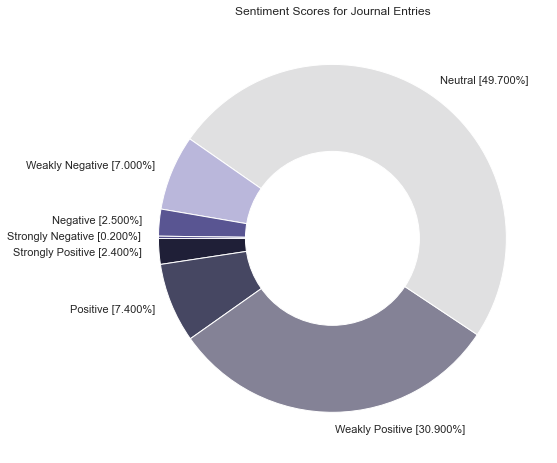

In [34]:
#donut chart of values
labels = ['Strongly Positive [' + str(spositive) + '%]','Positive [' + str(positive) + '%]',
          'Weakly Positive [' + str(wpositive) + '%]','Neutral [' + str(neutral) + '%]',
          'Weakly Negative [' + str(wnegative) + '%]','Negative [' + str(negative) + '%]', 
          'Strongly Negative [' + str(snegative) + '%]']
sizes = [spositive, positive, wpositive, neutral, wnegative, negative, snegative]
colors = ["#1f1f37",
          "#464762",
          "#848296",
          "#e0e0e1",          
          "#bab7db",         
          "#595592",
          "#352f76",] #colourblind (deutan) palette
patches, texts = plt.pie(sizes, colors=colors, startangle=180,labels=labels)
my_circle=plt.Circle( (0,0), 0.5, color='white')
p = plt.gcf()
p.set_size_inches(8,8)
p.gca().add_artist(my_circle)
plt.title("Sentiment Scores for Journal Entries")
#plt.savefig('sentiment_donut.png')
plt.show()

<sup> **Figure 3:** Sentiment Analysis based on all entries, using `textblob` polarity scoring </sup>

Sentiment analysis performed using `textblob polarity` assigned a single value score for each entry. This was subsequently classified within a seven-point Likert scale (_strongly negative - negative - weakly negative - neutral - weakly positive - positive - strongly positive_). Changes in step distributions change the outcomes somewhat: a wider neutral range results in neutral being the largest section; a narrower neutral range results in weakly positive being the largest section. Strongly negative sentiment is almost nonexistent, regardless of distributions (there appeared to be two entries with this classification). 

**Figure 3** features a colour palette of my own creation that is deuteranopia friendly (and tested on my Dad who is a deuteranope). 

### Journals Over Time

Because this data was scraped, rather than released directly by the Pandemic Journaling Project, we don't have a great way of figuring out when posts were made (journal dates weren't provided in the featured section or within HTML tags that could have been scraped). Manual analysis showed that many of the first entries referenced George Floyd's murder: May 25, 2020. This served as the start date. It's been approximately 45 weeks since then, and there were also 45 pages, so one page per week isn't a bad guess. Journal entries were thus put into weekly bins in order to examine word usage over time. 

Despite the apparent crudeness of this approach, it isn't wholly inaccurate: mentions of "Capitol" are bucketed in the January 9 group, three days after the riot.

In [35]:
ind_eng_sort = ind_eng.sort_values(by=['id']).reset_index(drop = True)

In [36]:
n_groups = 45
group = []
adj = []
for i in ind_eng_sort.index:
    l = round(len(ind_eng_sort)/n_groups)
    g = round(i/l)
    group.append(g)
    #this is the inverse of group, so we can use timedelta to measure backwards as weeks
    adj.append(abs(g - n_groups))

ind_eng_sort['group'] = group
ind_eng_sort['adj_group'] = adj

In [37]:
#generate the week buckets
rundate = pd.Timestamp('2021-04-03 15:34:41.258012') #my "today", don't move unless reruning (inc scraping)
#time delta for weeks
ind_eng_sort['date'] = rundate - pd.to_timedelta(ind_eng_sort['adj_group'], unit='w')

In [38]:
ind_eng_sort.head()

id               ids                                            entries  \
0   9   journal-entry-9  After the brutal murder of George Floyd by the...   
1  19  journal-entry-19  Today is day 87 since I began quarantine. Phil...   
2  31  journal-entry-31  We are going to be in this thing for a really ...   
3  53  journal-entry-53  I am sad and angry of the injustice and blatan...   
4  54  journal-entry-54  I had a wonderful conversation with a friend i...   

                                           tokenized  polarity  group  \
0  [After, the, brutal, murder, of, George, Floyd...  0.077679      0   
1  [Today, is, day, 87, since, I, began, quaranti... -0.055556      0   
2  [We, are, going, to, be, in, this, thing, for,...  0.314583      0   
3  [I, am, sad, and, angry, of, the, injustice, a... -0.045068      0   
4  [I, had, a, wonderful, conversation, with, a, ...  0.139105      0   

   adj_group                       date  
0         45 2020-05-23 15:34:41.258012  
1         45 2020-05-23 15:34:41.258012  
2         45 2020-05-23 15:34:41.258012  
3         45 2020-05-23 15:34:41.258012  
4         45 2020-05-23 15:34:41.258012

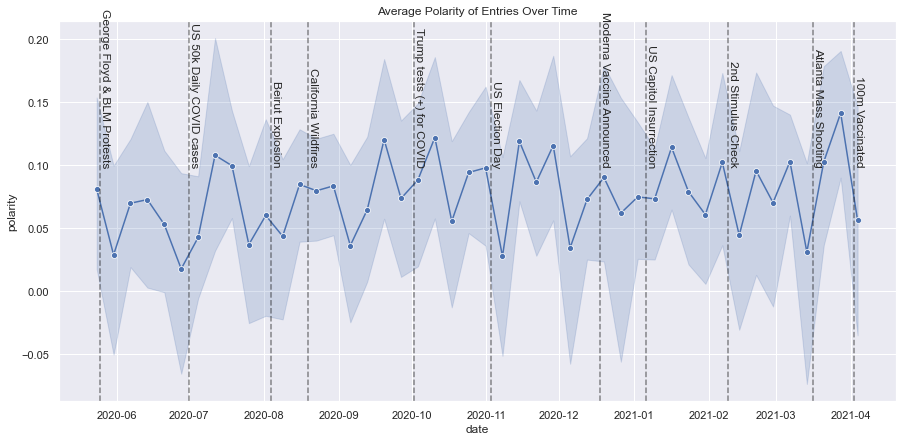

In [39]:
#proof of concept: plot sentiment polary over time
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(ax = ax, y="polarity", x="date", data=ind_eng_sort, marker= 'o')\
    .set_title('Average Polarity of Entries Over Time')

#add events
plt.axvline('2020-05-25',color='k',linestyle='--',alpha =.5)
plt.text('2020-05-25',.1,'George Floyd & BLM Protests',rotation=270)

plt.axvline('2020-07-01',color='k',linestyle='--',alpha =.5)
plt.text('2020-07-01',.1,'US 50k Daily COVID cases',rotation=270)

plt.axvline('2020-08-04',color='k',linestyle='--',alpha =.5)
plt.text('2020-08-04',.1,'Beirut Explosion',rotation=270)

plt.axvline('2020-08-19',color='k',linestyle='--',alpha =.5)
plt.text('2020-08-19',.1,'California Wildfires',rotation=270)

plt.axvline('2020-10-02',color='k',linestyle='--',alpha =.5)
plt.text('2020-10-02',.10,'Trump tests (+) for COVID',rotation=270)

plt.axvline('2020-11-03',color='k',linestyle='--',alpha =.5)
plt.text('2020-11-03',.10,'US Election Day',rotation=270)

plt.axvline('2020-12-18',color='k',linestyle='--',alpha =.5)
plt.text('2020-12-18',.10,'Moderna Vaccine Announced',rotation=270)

plt.axvline('2021-01-06',color='k',linestyle='--',alpha =.5)
plt.text('2021-01-06',.10,'US Capitol Insurrection',rotation=270)

plt.axvline('2021-02-09',color='k',linestyle='--',alpha =.5)
plt.text('2021-02-09',.10,'2nd Stimulus Check',rotation=270)

plt.axvline('2021-03-16',color='k',linestyle='--',alpha =.5)
plt.text('2021-03-16',.10,'Atlanta Mass Shooting',rotation=270)

plt.axvline('2021-04-02',color='k',linestyle='--',alpha =.5)
plt.text('2021-04-02',.10,'100m Vaccinated',rotation=270)
#plt.savefig('polarity_overtime_line.png')
plt.show()

<sup> **Figure 4:** Mapping polarity and dates, as a proof of concept </sup>

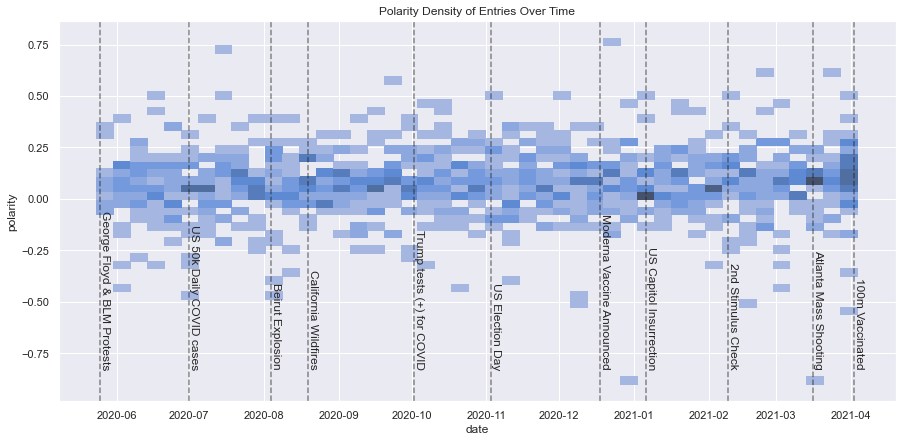

In [40]:
#proof of concept: bin sentiment score to show density as an alternative
fig, ax = plt.subplots(figsize = (15, 7))
sns.histplot(ax = ax, x="date",y='polarity', data=ind_eng_sort,bins = 45)\
    .set_title('Polarity Density of Entries Over Time') #45 bins == 45 weeks

#add events
plt.axvline('2020-05-25',color='k',linestyle='--',alpha =.5)
plt.text('2020-05-25',-.82,'George Floyd & BLM Protests',rotation=270)

plt.axvline('2020-07-01',color='k',linestyle='--',alpha =.5)
plt.text('2020-07-01',-.82,'US 50k Daily COVID cases',rotation=270)

plt.axvline('2020-08-04',color='k',linestyle='--',alpha =.5)
plt.text('2020-08-04',-.82,'Beirut Explosion',rotation=270)

plt.axvline('2020-08-19',color='k',linestyle='--',alpha =.5)
plt.text('2020-08-19',-.82,'California Wildfires',rotation=270)

plt.axvline('2020-10-02',color='k',linestyle='--',alpha =.5)
plt.text('2020-10-02',-.82,'Trump tests (+) for COVID',rotation=270)

plt.axvline('2020-11-03',color='k',linestyle='--',alpha =.5)
plt.text('2020-11-03',-.82,'US Election Day',rotation=270)

plt.axvline('2020-12-18',color='k',linestyle='--',alpha =.5)
plt.text('2020-12-18',-.82,'Moderna Vaccine Announced',rotation=270)

plt.axvline('2021-01-06',color='k',linestyle='--',alpha =.5)
plt.text('2021-01-06',-.82,'US Capitol Insurrection',rotation=270)

plt.axvline('2021-02-09',color='k',linestyle='--',alpha =.5)
plt.text('2021-02-09',-.82,'2nd Stimulus Check',rotation=270)

plt.axvline('2021-03-16',color='k',linestyle='--',alpha =.5)
plt.text('2021-03-16',-.82,'Atlanta Mass Shooting',rotation=270)

plt.axvline('2021-04-02',color='k',linestyle='--',alpha =.5)
plt.text('2021-04-02',-.82,'100m Vaccinated',rotation=270)
#plt.savefig('polarity_overtime_density.png')
plt.show()

<sup> **Figure 5:** Binning sentiment scores by week, as a proof of concept  </sup>

Efforts to plot sentiment score, even with an additional variable of time, feel very unsuccessful. Added vertical lines provide a lot of context to the year, but sentiments are likely moving much quicker than weekly groupings capture. The plots are generally uninteresting; **Figure 3** already shows that the vast majority of sentiment scores are either neutral or weakly positive. While both **Figure 4** and **Figure 5** allow us to explore the averages and density of sentiments throughout the time series, the sentiment scores are still far too positive to capture the mood. It is certainly interesting that some significant negative outliers do seem to correspond with major events, but the sentiment scores are too unreliable to draw compelling conclusions. 

In [41]:
#create frequency within each week grouping
freq_grouped = pd.DataFrame()
for i in range(min(ind_eng_sort['group']),max(ind_eng_sort['group'])):
    text = ind_eng_sort.query("group == @i")['entries'].apply(word_tokenize)
    words = sum(text, [])
    words = [w for w in words if w.isalpha()]
    words = [w for w in words if w.lower() not in stopwords]
    fd = nltk.FreqDist(words)
    freq = pd.DataFrame(list(fd.items()), columns = ['word','frequency'])
    freq['group'] = i
    freq_grouped = freq_grouped.append(freq)

In [42]:
#bring the date back in, get's lost in the frequency grouping, easier to just join it back in
freq_grouped = pd.merge(freq_grouped,ind_eng_sort[['group', 'date']],on='group', how='inner').drop_duplicates()

In [43]:
freq_grouped.iloc[np.r_[0:3, -3:0]]

word  frequency  group                       date
0          brutal          1      0 2020-05-23 15:34:41.258012
12         murder          1      0 2020-05-23 15:34:41.258012
24         George          2      0 2020-05-23 15:34:41.258012
807524   threaten          1     45 2021-04-03 15:34:41.258012
807545  frightens          1     45 2021-04-03 15:34:41.258012
807566   progress          1     45 2021-04-03 15:34:41.258012

In [44]:
freq_grouped.sort_values(by=['frequency'], ascending= False).head(5)

word  frequency  group                       date
505526   Trump         36     29 2020-12-12 15:34:41.258012
658701    love         28     36 2021-01-30 15:34:41.258012
18533   people         28      2 2020-06-06 15:34:41.258012
608487  people         28     34 2021-01-16 15:34:41.258012
747261  people         27     42 2021-03-13 15:34:41.258012

In [45]:
#top n words per group
n = 3
x = (freq_grouped.groupby('group').apply 
    (lambda x : x.sort_values(by = 'frequency', ascending = False).head(n).reset_index(drop = True)))

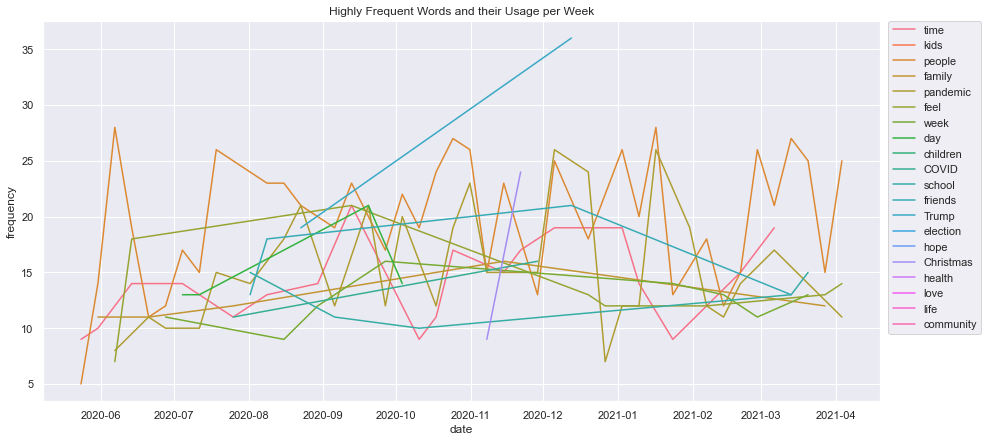

In [46]:
#proof of concept: most frequent words, truly a horrendous graph
fig, ax = plt.subplots(figsize = (15, 7))
sns.lineplot(ax = ax, x="date",y='frequency', hue = 'word' , data=x)\
    .set_title("Highly Frequent Words and their Usage per Week")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
#plt.savefig('topn_words_overtime.png')
plt.show()

<sup> **Figure 6:** Emphasizing top_n (5) words per group and each word's frequency, as a proof of concept </sup>

With established week groupings, it was interesting to revist `NTLK FreqDist`. This allows words to come and go relative to their occurrences in the time series. This is particularly important within the context of the Pandemic Journaling Project. References to George Floyd and Black Lives Matter protests marked the mood of early journals. This was replaced by the election cycle, culminating in the inauguration. 

While **Figure 6** is particularly horrendous to look at, it served as a strong inspiration for interactive Plotly graphics demonstrating the same concept. 

In [47]:
words_of_interest = ['normal','worry','hope','pandemic','family','vaccine','risk','lost','feel','kids','Trump']

#make an annotation for each of these words
#set y = to their highest point (this is done manually)
#match colour to line later
annotation_normal = \
[{"xref":"paper", "x":1, "y":14,
   "xanchor":"left", "yanchor":"middle",
   "text":'normal',
   "font":dict(family='Arial', size=15, color="#60BDF0"),
   "showarrow":False},]

annotation_worry = \
[{"xref":"paper", "x":1, "y":10,
  "xanchor":'left', "yanchor":'middle',
  "text":'worry',
  "font":dict(family='Arial',size=15,color="#9AC3D9"),
  "showarrow":False}]

annotation_hope = \
[{"xref":"paper", "x":1, "y":15,
  "xanchor":'left', "yanchor":'middle',
  "text":'hope',
  "font":dict(family='Arial',size=15,color="#5FAED9"),
  "showarrow":False}]

annotation_pandemic = \
[{"xref":"paper", "x":1, "y":26,
  "xanchor":'left', "yanchor":'middle',
  "text":'pandemic',
  "font":dict(family='Arial',size=15,color="#006AA3"),
  "showarrow":False}]

annotation_family = \
[{"xref":"paper", "x":1, "y":16,
  "xanchor":'left', "yanchor":'middle',
  "text":'family',
  "font":dict(family='Arial',size=15,color="#74AFCF"),
  "showarrow":False}]

annotation_vaccine = \
[{"xref":"paper", "x":1, "y":16,
  "xanchor":'left', "yanchor":'middle',
  "text":'vaccine',
  "font":dict(family='Arial',size=15,color="#656CBA"),
  "showarrow":False}]

annotation_risk = \
[{"xref":"paper", "x":1, "y":5,
  "xanchor":'left', "yanchor":'middle',
  "text":'risk',
  "font":dict(family='Arial',size=15,color="#2B317A"),
  "showarrow":False}]

annotation_lost = \
[{"xref":"paper", "x":1, "y":7,
  "xanchor":'left', "yanchor":'middle',
  "text":'lost',
  "font":dict(family='Arial',size=15,color="#080C3D"),
  "showarrow":False}]

annotation_feel = \
[{"xref":"paper", "x":1, "y":21,
  "xanchor":'left', "yanchor":'middle',
  "text":'feel',
  "font":dict(family='Arial',size=15,color="#111A7D"),
  "showarrow":False}]

annotation_school = \
[{"xref":"paper", "x":1, "y":15,
  "xanchor":'left', "yanchor":'middle',
  "text":'school',
  "font":dict(family='Arial',size=15,color="#222657"),
  "showarrow":False}]

annotation_Trump = \
[{"xref":"paper", "x":1, "y":36,
  "xanchor":'left', "yanchor":'middle',
  "text":'Trump',
  "font":dict(family='Arial',size=15,color="black"),
  "showarrow":False}]


In [48]:
#let's make the previous interactive instead with plotly

#sort the dataframe so the lines don't overlap
#frequency needs to be at least 3 or this will be wayyy to slow
sorted_df = freq_grouped.query('frequency > 2').copy() #map the value order
#if you want to change words you MUST change them here
sorted_df["order"] = sorted_df["word"].map({'normal':1,'worry':2,'hope':3,'pandemic':4,'family':5,
   'vaccine':6,'risk':7,'lost':8,'feel':9,'school':10,'Trump':11}).fillna(12) #sort by this order
sorted_df.sort_values(by=["order","group"], ascending=False, inplace=True)

#make the base line chart
fig = px.line(sorted_df, x="date", y="frequency", color="word",
              line_group="word", line_shape="spline", render_mode="svg")

#for the interactivity we need to know which traces belong to each word
traces = {}
for i,d in enumerate(fig.to_dict()["data"]):
    traces[d["legendgroup"]] = i
        
#make every other word light grey
fig.update_traces({"line":{"color":"lightgrey"}})

#fig aesthetics
fig.update_layout(title="Frequent Words Over Time",
                #remove the legend
                showlegend=False,                                          
                #create big enough margins for our annotations
                margin={"l":50, "r": 100},            
    #buttons (note to self: please figure out how to loop this in the future)
    updatemenus=[
        dict(buttons=list([
                dict(args=[{"line.color":["#60BDF0"],"line.width":5}, 
                         {"title":"Frequent Words Over Time: normal",
                           "annotations": annotation_normal}, [traces["normal"]]],    
                    #args2 used as toggle button, applies when clicked on active button
                    args2=[{"line.color":["lightgrey"],"line.width":2},
                           {"title":"Frequent Words Over Time",
                            "annotations": None}], label="normal",method="update",)
                ,dict(args=[{"line.color":["#9AC3D9"],"line.width":5}, 
                         {"title":"Frequent Words Over Time: worry",
                          "annotations": annotation_worry}, [traces["worry"]]],  
                    args2=[{"line.color":["lightgrey"],"line.width":2},
                           {"title":"Frequent Words Over Time",
                            "annotations": None}],label="worry",method="update",)
                ,dict(args=[{"line.color":["#5FAED9"],"line.width":5}, 
                         {"title":"Frequent Words Over Time: hope",
                          "annotations": annotation_hope}, [traces["hope"]]],  
                    args2=[{"line.color":["lightgrey"],"line.width":2},
                           {"title":"Frequent Words Over Time",
                            "annotations": None}],label="hope",method="update",)
                ,dict(args=[{"line.color":["#006AA3"],"line.width":5}, 
                         {"title":"Frequent Words Over Time: pandemic",
                          "annotations": annotation_pandemic}, [traces["pandemic"]]],  
                    args2=[{"line.color":["lightgrey"],"line.width":2},
                           {"title":"Frequent Words Over Time",
                            "annotations": None}], label="pandemic",method="update",)          
                ,dict(args=[{"line.color":["#74AFCF"],"line.width":5}, 
                         {"title":"Frequent Words Over Time: family",
                          "annotations": annotation_family}, [traces["family"]]],  
                    args2=[{"line.color":["lightgrey"],"line.width":2},
                           {"title":"Frequent Words Over Time",
                            "annotations": None}],label="family",method="update",)
                ,dict(args=[{"line.color":["#656CBA"],"line.width":5}, 
                         {"title":"Frequent Words Over Time: vaccine",
                          "annotations": annotation_vaccine}, [traces["vaccine"]]],  
                    args2=[{"line.color":["lightgrey"],"line.width":2},
                           {"title":"Frequent Words Over Time",
                            "annotations": None}],label="vaccine",method="update",)
                ,dict(args=[{"line.color":["#2B317A"],"line.width":5}, 
                         {"title":"Frequent Words Over Time: risk",
                          "annotations": annotation_risk}, [traces["risk"]]],  
                    args2=[{"line.color":["lightgrey"],"line.width":2},
                           {"title":"Frequent Words Over Time",
                            "annotations": None}],label="risk",method="update",)
                ,dict(args=[{"line.color":["#080C3D"],"line.width":5}, 
                         {"title":"Frequent Words Over Time: lost",
                          "annotations": annotation_lost}, [traces["lost"]]],  
                    args2=[{"line.color":["lightgrey"],"line.width":2},
                           {"title":"Frequent Words Over Time",
                            "annotations": None}],label="lost", method="update",)
                ,dict(args=[{"line.color":["#111A7D"],"line.width":5}, 
                         {"title":"Frequent Words Over Time: feel",
                          "annotations": annotation_feel}, [traces["feel"]]],  
                    args2=[{"line.color":["lightgrey"],"line.width":2},
                           {"title":"Frequent Words Over Time",
                            "annotations": None}],label="feel", method="update",)
                ,dict(args=[{"line.color":["#222657"],"line.width":5}, 
                         {"title":"Frequent Words Over Time: school",
                          "annotations": annotation_school}, [traces["school"]]],  
                    args2=[{"line.color":["lightgrey"],"line.width":2},
                           {"title":"Frequent Words Over Time",
                            "annotations": None}],label="school",method="update",)               
                ,dict(args=[{"line.color":["black"],"line.width":5}, 
                         {"title":"Frequent Words Over Time: Trump",
                          "annotations": annotation_Trump}, [traces["Trump"]]],  
                    args2=[{"line.color":["lightgrey"],"line.width":2},
                           {"title":"Frequent Words Over Time",
                            "annotations": None}],label="Trump",method="update")              
            ]),
            type = "buttons",
            direction="left",
            showactive=True,
            x=0,xanchor="left",
            y=1,yanchor="middle"
        )]
    )

#display the plot
fig.show()

<sup> **Figure 7:** An interactive plot for 11 interesting words and each word's frequency </sup>

In [49]:
#loop the words as a scrollytelling 
words_of_interest = ['normal','worry']
colours = ["#60BDF0","#9AC3D9"]

for idx, val in enumerate(words_of_interest):
    
    #sort the dataframe
    sorted_df = freq_grouped.query('frequency > 2').copy()
    sorted_df["order"] = sorted_df["word"].map({words_of_interest[idx]: 1}).fillna(2) 
    sorted_df.sort_values(by=["order","group"], ascending=False, inplace=True)

    fig = px.line(sorted_df, x="date", y="frequency", color="word",
                  line_group="word", line_shape="spline", render_mode="svg")

    #edit colors
    for d in fig['data']:
        if d['name'] == words_of_interest[idx]:
            d['line']['color']= colours[idx]
            d['line']['width']=5
        else:
            d['line']['color']='lightgrey'
            d['line']['width']=2
    
    #add title for each word
    fig.update_layout(title=str("Frequent Words Over Time: "+ val), showlegend=False)
    
    
    fig.show()

<sup> **Figure 8:** An altnerative "scrollytelling" concept, where each plotly would be presented in succession -- but the notebook became too slow with more than a few words, so buttons were built instead </sup>

After building **Figure 7** and **Figure 8**, I prefer the "scrollytelling" concept over the button functionality. There are pros and cons to both: the button concept allows for comparison across words, while the single plots create more of a narrative structure (especially when  more than two words are presented). The button concept doesn't allow for perfect sorting (words overlap to some extent) and the toggling on/off functionality is a bit odd. The single plots repeat the same information over and over again, but with a narrative between plots, users can focus strictly on the highlighted word. 

Additionally, because the Pandemic Journaling Project is still in progress, I think either concept can be positioned as a useful tool for researchers. With some clever python, the highlighted words could be more dynamic (e.g. an input box that allowed users to query the data for up to 10 words). The researchers have stated the project will run until the WHO declares that COVID-19 is no longer a "pandemic".

### References

The Pandemic Journaling Project:

    Mason, K. A., & Willen, S. (2020, April 08). The Pandemic Journaling Project. Retrieved April 04, 2021, from https://pandemic-journaling-project.chip.uconn.edu/

    Carey, B. (2021, February 15). ‘Right Now Feels So Long and Without Any End in Sight’. Retrieved April 04, 2021, from https://www.nytimes.com/2021/02/15/science/science-covid-mental-health.html 
        A version of this article appears in print on Feb. 16, 2021, Section D, Page 8 of the New York edition 
        with the headline: Dear Diary: This Pandemic Has Been a Bear.

And some really fantastic guides for this notebook, because the coding is quite complex:

    Dekanovsky, V. (2020, November 12). Highlighted line chart with plotly.express. Retrieved April 04, 2021, from https://towardsdatascience.com/highlighted-line-chart-with-plotly-express-e69e2a27fea8
    
    Mogyorosi, M. (2021, February 13). Sentiment analysis: First steps with Python's NLTK library. Retrieved April 04, 2021, from https://realpython.com/python-nltk-sentiment-analysis/

Colourblind palette work done through:

    Bianchi, F. (2014, October). Coolors. Retrieved April 04, 2021, from https://coolors.co/

### Appendix

**The following R code can be run to generate the csv file loaded into this notebook**

```r
#load libraries
library(lubridate)
library(dplyr)
library(tidyr)
library(readr)
library(tibble)
library(data.table)
library(rvest)
library(stringr)
library(here)

#get rundate for file names
rundate = toString(sapply(date(now()), gsub, pattern = "-", replacement = "", fixed = TRUE))

#currently there are 45 pages, this generates a tibble of those URLs with "&page=1..." through "&page=45"
URLs <- data.frame()
for(i in 1:45){
  x <- paste0("https://www.pandemicjournalingproject.org/en/archive/featured?entry_type=text_only&page=",i,"&search=")
  x <- tibble(x)
  URLs <- rbind(x,URLs)
}

#create as URLs instead
URLs <- URLs$x

#remove any URLs that resolve to 404/similar
checkURLs <- lapply(URLs, function(u) {
  tryCatch({
    html_obj <- read_html(u)
    draft_table <- html_nodes(html_obj,'table')
    cik <- substr(u,start = 41,stop = 47)
    draft1 <- html_table(draft_table,fill = TRUE)
    final <- u
  }, error = function(x) NULL)
})

#remove the 404s -- there are none, but the for loop would break if there were any
URLs <- unlist(checkURLs)

#create our ouput dataframe
entries_all <- data.frame()

#run for loop for each page in the pandemic journaling project
for(i in URLs){
  raw_data <- read_html(i)
  
  #scrape the entry value based on class = "row" from html_nodes
  entries <- raw_data %>%
    html_nodes("div [class = 'row']") %>% 
    html_text()

  #tibble
  entries <- tibble(entries)
  
  #scrape the journal id value based on html_nodes
  ids <- raw_data %>% 
    html_nodes("div div div div ") %>%
    html_attr("id")

  #tibble and remove the NA rows
  ids <- tibble(ids) %>% filter(!is.na(ids))
  
  #join ids and entries
  entries_joined <- left_join(rownames_to_column(ids), rownames_to_column(entries), by = ("rowname" = "rowname"))

  #bind to output dataframe
  entries_all <- rbind(entries_joined,entries_all)
  
  #slow the scraper down, five seconds between each page
  Sys.sleep(5)
}

#write to csv
path_out = paste0(getwd(),'/data/')
file_name = paste0(path_out, 'PandemicJournalingProject_',rundate,'.csv')
write_csv(entries_all,file_name)
```

**Image Appendix**

![A static image of Figure 1](imgs/Figure_1.png)

<sup> **Figure A:** A static image of Figure 1 in case the notebook isn't trusted, or libraries are not installed </sup>

![A static image of Figure 2](imgs/Figure_2.png)

<sup> **Figure B:** A static image of Figure 2 in case the notebook isn't trusted, or libraries are not installed </sup>

![A static image of Figure 3](imgs/Figure_3.png)

<sup> **Figure C:** A static image of Figure 3 in case the notebook isn't trusted, or libraries are not installed </sup>

![A static image of Figure 4](imgs/Figure_4.png)

<sup> **Figure D:** A static image of Figure 4 in case the notebook isn't trusted, or libraries are not installed </sup>

![A static image of Figure 5](imgs/Figure_5.png)

<sup> **Figure E:** A static image of Figure 5 in case the notebook isn't trusted, or libraries are not installed </sup>

![A static image of Figure 6](imgs/Figure_6.png)

<sup> **Figure F:** A static image of Figure 6 in case the notebook isn't trusted, or libraries are not installed </sup>

![A static image of Figure 7](imgs/Figure_7_normal.png)

<sup> **Figure G:** A static image of Figure 7, where "normal" is selected from the buttons, in case the notebook isn't trusted, or libraries are not installed </sup>

![A static image of Figure 7](imgs/Figure_7_trump.png)

<sup> **Figure H:** A static image of Figure 7, where "Trump" is selected from the buttons, in case the notebook isn't trusted, or libraries are not installed </sup>

![A static image of Figure 8](imgs/Figure_8.png)

<sup> **Figure I:** A static image of Figure 8 in case the notebook isn't trusted, or libraries are not installed </sup>

![nltk_data folder example](imgs/nltk_data.png)

<sup> **Figure J:** An example of required `nltk` resources saved required to run this notebook, saved in my root folder as "nltk_data"  </sup>

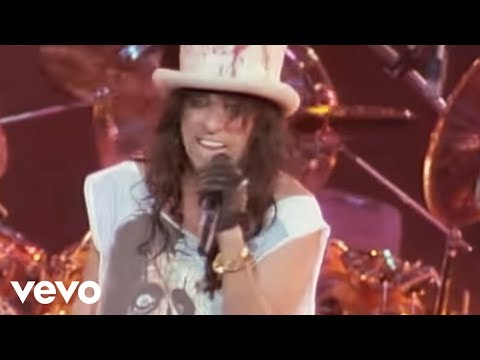

In [50]:
from IPython.display import YouTubeVideo

YouTubeVideo('2Oo8QzDHimQ', width=560, height=315)

<sup> **Video A:** Alice Coopers's School's Out, because I'm glad to knock a final assignment off my to do list, and of course, for your enjoyment. Thanks for the course ✌️ </sup>